# Finding a functional roll in a slding window across a BGC

## 1. Datafiles required
In this tutorial we will use the following file:  
 I.`mibig_prot_seqs_2.0.fasta` a fasta file of the MIBiG database.    
 II.`antibiotics-metadata.tsv` a tab-separated file with MIBiG metadata.    
 III.`Rast-ids.tsv` a tab separated file with Rast Ids.  
 
 
- 1.1 Lets see the first lines of the file `mibig_prot_seqs_2.0.fasta`

In [5]:
conda install -c bioconda blast

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - blast


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blast-2.5.0                |       hc0b0e79_3       137.8 MB  bioconda
    boost-1.74.0               |   py37he5a615d_2         335 KB  conda-forge
    boost-cpp-1.74.0           |       h9d3c048_1        16.3 MB  conda-forge
    bzip2-1.0.8                |       h516909a_3         398 KB  conda-forge
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    certifi-2020.11.8          |   py37h89c1867_0         150 KB  conda-forge
    icu-68.1                   |       h58526e2_0        13.0 MB  conda-forge
    libb

In [8]:
conda install -c conda-forge matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.73.0               |          py37_11          25 KB  defaults
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    dbus-1.13.6                |       hfdff14a_1         585 KB  conda-forge
    expat-2.2.9                |       he1b5a44_2         191 KB  conda-forge
    fontconfig-2.13.1          |    he4413a7_1000         327 KB  conda-forge
    freetype-2.10.4            |       h7ca028e_0         912 KB  conda-forge
    gettext-0.19.8.1           |    hf34092f_1004         3.6 MB  conda-forge
   

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
%%bash
head -n4 mibig_prot_seqs_2.0.fasta

>BGC0000001_AEK75490
MTELDRAFDAVPAPIYTHHERHGETVHRSAPESIRRELAALQVRAGDRVLEIGTGSGYSGALLAHLCCPDGQVTSIDISDELVRRAAAIHAERGVTSVDCHVGDGLAGYPAAAPFHRAVSWCAPPRLPRAWTQQVVNGGRIVACLPITALPSTTLIATITVAAGKPRIEALAGGGYAQSTPVAVDDALTVPGRWVDYCDRQPDPSWIGICWRSADDAQHTGARSALGQLLHPGYTDTYRQMEPHWRSWYTWTSALGDPQLSLVSLRNEIRGLGHTTPSSAAVILTDGRVIADRPDSPSLRSLRTWLQRWEHVGRPAPESFARTLVPHDCPDLAGWDLQVGHGSVTTDRQPPRRVDEPRRP	
>BGC0000001_AEK75491
MKPPASSVCPVDTSKMGNRSSPARYGRRPRKRCVELSETNLEFVHVVHRRHGHDDPRLGFFFLATAWQGQPVNREPHKCAGLVWTDPAQPPATTIAYTVAALEQIHSGRPFSLDGWAEHSPSATGCGIVDVAWEPPVRRGQREPRHQHDDGGRHGYTVGQPDPCRPLLGCRSTAHPTGCRPRRNVSSWLQLSPRTPGPYAISLMSRER	


- 1.2 Lets see the first lines of the file `antibiotics-metadata.tsv`

In [2]:
%%bash
head -n4  antibiotics-metadata.tsv  

SSV-2083	Streptomyces sviceus ATCC 29083	ABJJ02		Complete	no	yes													Lanthipeptide	BGC0000579	
himastatin	Streptomyces himastatinicus ATCC 53653	ACEX01		Unknown	yes	yes	2211362	yes					yes					cyclohexadepsipeptide	NRP	BGC0001117	
phosphinothricintripeptide	Streptomyces viridochromogenes	ACEZ01		Complete	yes	yes	1367200,11472937	yes										Aminobutyrates	NRP	BGC0000406	
hormaomycin, hormaomycin A1, hormaomycin A2, hormaomycin A3, hormaomycin A4, hormaomycin A5, hormaomycin A6	Streptomyces griseoflavus	ACFA01		Complete	yes	yes	21439483	yes										peptide lactone	Cyclic depsipeptide	BGC0000374	bacterial signaling


**This table contian genome Id when available** Notice that column three contains genome NCBI Id in the case that the species that produces this BGC has a complete genome available at NCBI.

In [2]:
%%bash
cut -f 3 antibiotics-metadata.tsv  | sort| uniq | head -n3



ABJJ02
ACEX01



- 1.3 Lets see the first lines of the file `Rast-ids.tsv`

In [3]:
%%bash 
head -n4 Rast-ids.tsv

951719	1887.7	Streptomyces albogriseolus LBX-2 CP042594.1
951562	1956.5	Streptomyces diastaticus SID7513 JAAGMO001
951693	1960.12	Streptomyces vinaceus ATCC 27476 CP023692.1
951703	40318.14	Streptomyces nodosus ATCC 14899 CP023747.1


**Rast Job Id** This tab separated file contains three columns, the first one is the RAST Job Id, second one RAST genome Id and finally the  third column contains the organisms name.

##. Blast databases

## 3. Obtaining BGC borders
First we will run `getSeq.sh` to obtain the sequences at the borders of a each BGC.  
`bash getSeq <BGC> <MiBiG fasta file>`  

- 1 BGCId 
- 2 MiBiG fasta db (default mibig_prot_seqs_2.0.fasta)
- 3 MiBig metadata including in third column genome Id if exist (antibiotics-metadata.tsv)
- 4 File with Rast Ids (Rast-ids.tsv)
- 5 Sliding Window size (10 in this tutorial)
- 6 Number of windows (5 in this tutorial) 
- 7 Functional word to search in genome functional annotation file (ansporter that stands for [Tt]ransporters  

This script needs as input a BGC Id from MIBiG and the MIBiG fasta file, for example `BGC0000406`.      
- getSeq obtains the fasta files `BGC0000406.i` and `BGC0000406.f`   that stands for initial and final sequence of the BGC.  
- Identifies the genome that contains this BGC using the metadata file.  
- Run a Blast search and finds the best hit of each one of the border sequences. 
- If they correspond to the BGC, call the perl script `getTrans.pl` to serach in the annotation file genes taht corresponds to the functional category in a sliding window.
  src/getTrans.pl 6772 6744 220639 BGC0000406 10 5 ansporter




2.1 First lets see that at the moment, there are not files with extensions .i or .f

In [5]:
ls *i *f

BGC0000406.f  BGC0000406.i


2.2 Now lets run getSeq

In [6]:
  %%bash src/getSeq.sh BGC0000406 mibig_prot_seqs_2.0.fasta antibiotics-metadata.tsv Rast-ids.tsv 10 5 ansporter
    

BGC BGC0000406 genome ACEZ01 file 220639
src/getTrans.pl 6772 6744 220639 BGC0000406 10 5 ansporter
BGC0000406	0	1	1	1	4	6


2.3 Find the genome file that corresponds to this BGC
BGC BGC0000431 genome ABYB01 file 512417

2.4 Find the corresponding border gene in that genome
getTrans.pl 635 656 512417 BGC0000431


2.5 Look in a window if there are transporters
BGC0000406	0	0	0	0	0

Text(0, 0.5, 'Number of Genes classified as transporter related ')

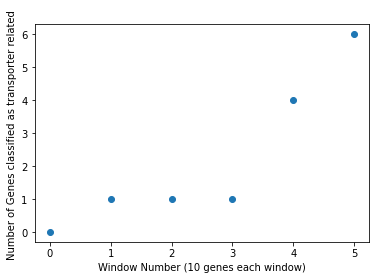

In [12]:
windowNumber = [0, 1, 2, 3,4,5]
transporterGenes = [0,1,1,1,4,6]

plt.scatter(windowNumber, transporterGenes)
plt.xlabel('Window Number (10 genes each window)')
plt.ylabel('Number of Genes classified as transporter related ')